In [113]:
include <- function(pkg) {
  if (!suppressMessages(require(pkg, character.only = TRUE)))
    install.packages(pkg, character.only = TRUE)
  suppressMessages(library(pkg, pkg, character.only = TRUE))
}
include("ShortRead")
include("plyr")
include("magick")

Installing package into ‘/home/magus/R/x86_64-redhat-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)



In [36]:
BASE_PATH_NR1 = "/data/samples/AIRR-Seq/OURS/S3987Nr1"
BASE_PATH_NR2 = "/data/samples/AIRR-Seq/OURS/S3987Nr2"

SAMPLES = list(
    list(base_path=BASE_PATH_NR1, name="S3987Nr1-PBMC1_heavy"),
    list(base_path=BASE_PATH_NR1, name="S3987Nr1-PBMC1_light"),
    list(base_path=BASE_PATH_NR1, name="S3987Nr1-RAMOS_heavy"),
    list(base_path=BASE_PATH_NR1, name="S3987Nr1-RAMOS_light")
#     list(base_path=BASE_PATH_NR2, name="S3987Nr2-PBMC1_heavy"),
#     list(base_path=BASE_PATH_NR2, name="S3987Nr2-PBMC1_light"),
#     list(base_path=BASE_PATH_NR2, name="S3987Nr2-RAMOS_heavy"),
#     list(base_path=BASE_PATH_NR2, name="S3987Nr2-RAMOS_light")
)

EXCLUDE_FROM_DIVERSITY_ANALYSIS = c(
    "S3987Nr1-RAMOS_heavy"
)

In [165]:
# Helpers
get_path_sample <- function(sample_name, base_path = BASE_PATH) {
    return(paste0(base_path, "/", sample_name))
}

get_path_fastq <- function(sample_name, type = "raw", base_path = BASE_PATH) {
    
    if (type == "raw") {
        return(
            paste0(
                get_path_sample(sample_name, base_path),
                "/", sample_name, ".1.fastq"
            )
        )
    } else if (type == "primer_pass") {
        suffix = ".1_primers-pass.fastq"
    } else if (type == "pair_pass"){
        suffix = ".1_primers-pass_pair-pass.fastq"
    } else if (type == "under2") {
        suffix = "_under-2.fastq"
    } else if (type == "atleast2") {
        suffix = "_atleast-2.fastq"
    } else {
        stop(paste0("Unsupported fastq file type: ", type))
    }
    
    return(
        paste0(
            get_path_sample(sample_name, base_path),
            "/", "presto",
            "/", sample_name, suffix
        )
    )
}

get_path_igblast <- function(sample_name, base_path = BASE_PATH) {
    return(
        paste0(
            get_path_sample(sample_name, base_path), 
            "/", "changeo_igblast", 
            "/", sample_name, "_db-pass_with_translation.tsv"
        )
    )
}

get_path_clones <- function(sample_name, clone_file = "groups", base_path = BASE_PATH) {
    
    if (clone_file == "groups") {
        suffix = "_vjl_groups.tsv"
    } else if (clone_file == "clones") {
        suffix = "_with_clones.tsv"
    } else if (clone_file == "counts") {
        return(
            paste0(
                get_path_sample(sample_name, base_path),
                "/", "clones", 
                "/", "diversity",
                "/", sample_name, "_clone_counts.tsv"
            )
        )
    } else {
        stop(paste0("Unknown clone_file type: ", clone_file))
    }
    
    return(
        paste0(
            get_path_sample(sample_name, base_path),
            "/", "clones", 
            "/", sample_name, suffix
        )
    )
}

get_path_coverages <- function(sample_name, base_path = BASE_PATH) {
    return(
        paste0(
            get_path_sample(sample_name, base_path),
            "/", "clones",
            "/", "diversity",
            "/", sample_name, "_coverages.tsv"
        )
    )
}

get_path_pngs <- function(sample_name, img_type = "abundancy", base_path = BASE_PATH) {
    
    if (img_type == "abundancy") {
        suffix = "_abundancy_curve.png"
    } else if (img_type == "diversity") {
        suffix = "_diversity.png"
    } else {
        stop("Image type = ", img_type, " is not supported.")
    }
    
    return(
        paste0(
            get_path_sample(sample_name, base_path),
            "/", "clones",
            "/", "diversity",
            "/", sample_name, suffix
        )
    )
}

read_tsv <- function(filepath) {
    return(read.csv(filepath, sep='\t'))
}

### Characterize sequencing results for each sample

In [16]:
count_reads_fastq <- function(fastq_path) {
    return(
        ShortRead::countFastq(fastq_path)$records
    )
}

In [17]:
res <- sapply(
    SAMPLES,
    function(sample) {
        counts = cbind(
            sample$name,
            count_reads_fastq(get_path_fastq(sample$name, type = "raw", sample$base_path)),
            count_reads_fastq(get_path_fastq(sample$name, type = "primer_pass", sample$base_path)),
            count_reads_fastq(get_path_fastq(sample$name, type = "pair_pass", sample$base_path)),
            count_reads_fastq(get_path_fastq(sample$name, type = "under2", sample$base_path)),
            count_reads_fastq(get_path_fastq(sample$name, type = "atleast2", sample$base_path))
        )
        return(counts)
    }
)

res <- data.frame(t(res))
colnames(res) = c("sample_name", "raw", "primer_pass", "pair_pass", "under2", "atleast2")
head(res)

,sample_name,raw,primer_pass,pair_pass,under2,atleast2
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,S3987Nr1-PBMC1_heavy,293087,293087,293087,127350,14008
2,S3987Nr1-PBMC1_light,264459,264459,264459,108203,13384
3,S3987Nr1-RAMOS_heavy,160952,160952,160952,28,5
4,S3987Nr1-RAMOS_light,69991,69991,69991,25974,3791


### Compare clone counts

In [173]:
sample = SAMPLES[[4]]

clone_counts = data.frame()
for (i in 1:length(SAMPLES)) {
    
    sample = SAMPLES[[i]]
    filepath = get_path_clones(sample$name, "counts", sample$base_path)
    
    if (file.exists(filepath)) {
        df = head(read_tsv(filepath))
        df_ann = cbind(sample$name, df)
        clone_counts <- plyr::rbind.fill(clone_counts, df_ann)
    } else {
        print(paste0("Filepath not found: ", filepath))
    }
}

clone_counts

[1] "Filepath not found: /data/samples/AIRR-Seq/OURS/S3987Nr1/S3987Nr1-RAMOS_heavy/clones/diversity/S3987Nr1-RAMOS_heavy_clone_counts.tsv"


sample$name,clone_id,seq_count,copy_count,seq_freq,copy_freq
<chr>,<int>,<int>,<int>,<dbl>,<dbl>
S3987Nr1-PBMC1_heavy,556,1628,24866,0.1248370524,0.1944251144
S3987Nr1-PBMC1_heavy,374,718,10748,0.0550571275,0.0840376872
S3987Nr1-PBMC1_heavy,900,781,8913,0.0598880454,0.0696899801
S3987Nr1-PBMC1_heavy,453,533,8079,0.0408710988,0.0631690058
S3987Nr1-PBMC1_heavy,1316,536,7377,0.0411011426,0.0576801282
S3987Nr1-PBMC1_heavy,1216,333,3103,0.0255348516,0.0242620900
S3987Nr1-PBMC1_light,148,2122,29546,0.1661316840,0.2304374615
S3987Nr1-PBMC1_light,268,764,10638,0.0598136695,0.0829687171
S3987Nr1-PBMC1_light,171,667,7790,0.0522195256,0.0607563740


### Abundancy and diversity comparisons among samples

In [22]:
# Get data
sample = SAMPLES[[1]]

igblast <- read_tsv(
    get_path_igblast(sample$name, sample$base_path)
)

clone_groups <- read_tsv(
    get_path_clones(sample$name, "groups", sample$base_path)
)

clones <- read_tsv(
    get_path_clones(sample$name, "clones", sample$base_path)
)

abundancy_curve_png <- 

# print("IgBlast");colnames(igblast);head(igblast);
# print("Clone groups");colnames(clone_groups);head(clone_groups);
# print("Clones");colnames(clones);head(clones)

In [108]:
coverages <- lapply(
    SAMPLES,
    function(sample, exclude) {
        if (sample$name %in% exclude) {
            return(NULL)
        } else {
            return((read_tsv(get_path_coverages(sample$name, sample$base_path))))
        }
    },
    EXCLUDE_FROM_DIVERSITY_ANALYSIS
)

coverages_df <- data.frame()
for (i in 1:length(SAMPLES)) {
    sample <- SAMPLES[[i]]
    cov <- coverages[[i]]
    if (!is.null(cov)) {
        cov_annotated <- rbind(sample$name, cov)
        coverages_df <- plyr::rbind.fill(coverages_df, cov_annotated)
    } else {
        coverages_df <- rbind(coverages_df, sample$name)
    }
}
coverages_df

In [ ]:
magick::image_append(magick::image_scale(img, "100"), stack = TRUE)

In [159]:
img1 = magick::image_read(get_path_pngs(SAMPLES[[1]]$name, "abundancy", SAMPLES[[1]]$base_path))
img2 = magick::image_read(get_path_pngs(SAMPLES[[2]]$name, "abundancy", SAMPLES[[2]]$base_path))
img4 = magick::image_read(get_path_pngs(SAMPLES[[4]]$name, "abundancy", SAMPLES[[4]]$base_path))
comb_img = magick::image_append(c(img1, img2, img4), stack=TRUE)
magick::image_write(comb_img, path = "tiger.png", format = "png")

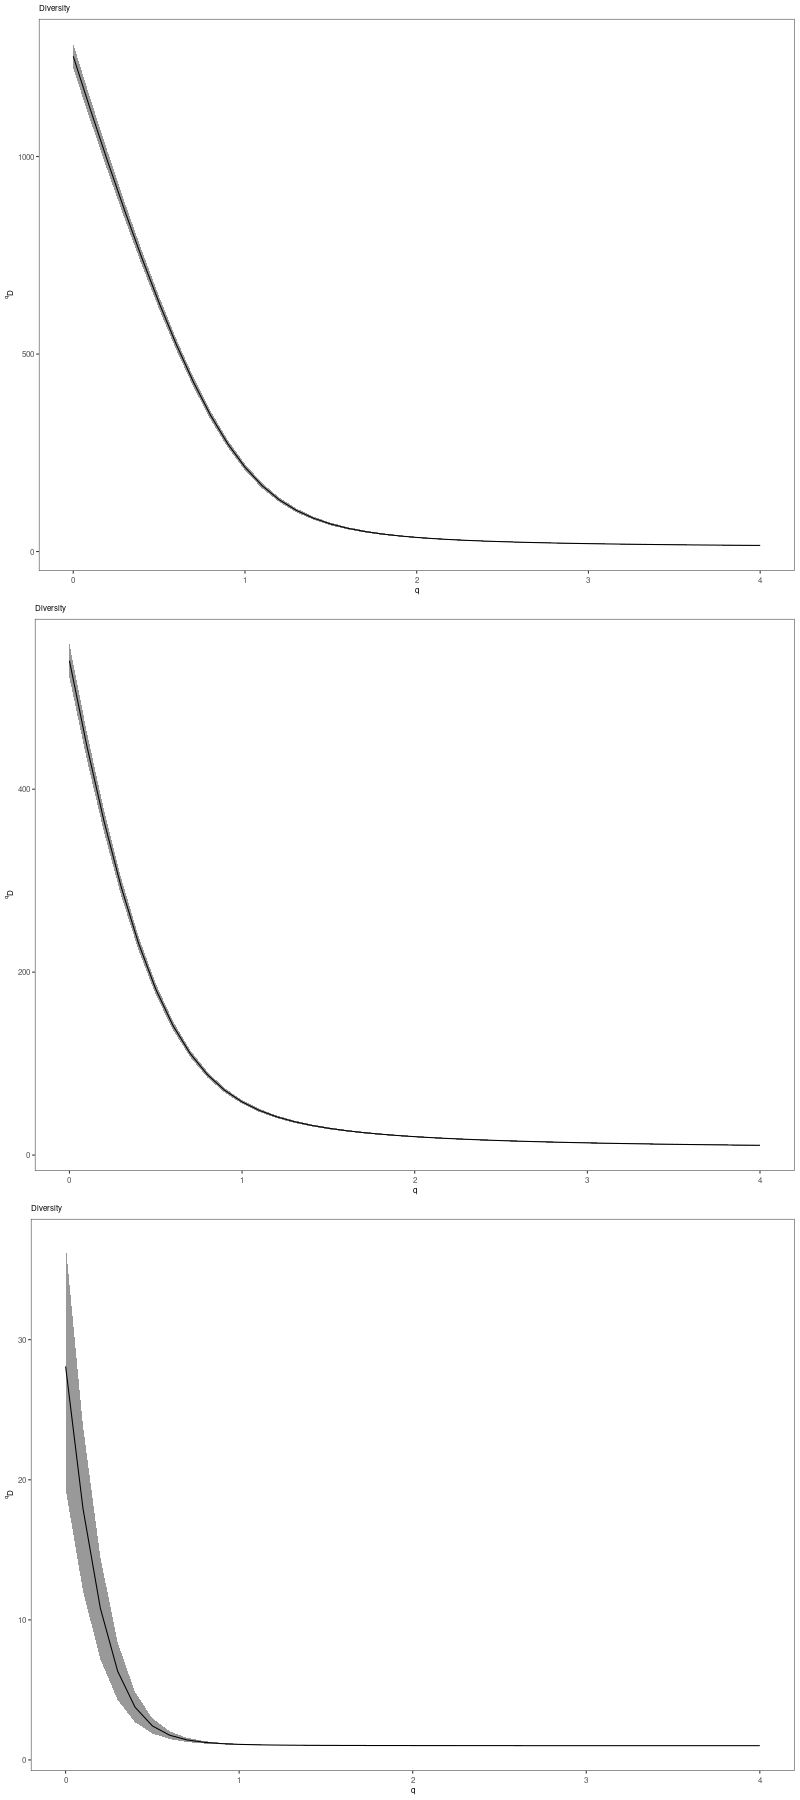

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      800   1800 sRGB       FALSE        0 72x72  

In [126]:
img1 = magick::image_read(get_path_pngs(SAMPLES[[1]]$name, "diversity", SAMPLES[[1]]$base_path))
img2 = magick::image_read(get_path_pngs(SAMPLES[[2]]$name, "diversity", SAMPLES[[2]]$base_path))
img4 = magick::image_read(get_path_pngs(SAMPLES[[4]]$name, "diversity", SAMPLES[[4]]$base_path))

comb_img = comb_img = magick::image_append(c(img1, img2, img4), stack=TRUE)
magick::image_write(comb_img, path = "tiger.png", format = "png")